In [39]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import pickle

import data.datautil as du
from models import TransformerEncoder, TransformerDecoder, StateTransition, RULEstimator

In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [41]:
# data_name='Rectifier_oct23_input_constant'
# sim_name='RectifierData_step10h' 
# dataset_name='RUL_real'

In [42]:
data_name='Rectifier_oct23_cap'
sim_name='RectifierData_step10h' 
dataset_name='RUL_real_cap'

In [43]:
# data_name='Rectifier_nov23_4steps_perform3'
# sim_name='RectifierData_step10h' 
# dataset_name='RUL_real'

In [44]:
with open(f'./data/{data_name}/dataset_{dataset_name}_train.pkl', 'rb') as file:
    train_dataset = pickle.load(file)
    
batch_size = 64
stats = ['X']
timestep=9
window={'X':[timestep,0],'Y':[0,0]}
trainloader = du.create_loader(train_dataset, batch_size, stats, window=window, shuffle=True) # for now, don't shuffle
trainloader

In [45]:
with open(f'./data/{data_name}/dataset_{dataset_name}_test.pkl', 'rb') as file:
    test_dataset = pickle.load(file)
    
batch_size = 128
stats = ['X']
timestep=9
window={'X':[timestep,0],'Y':[0,0]}
testloader = du.create_loader(test_dataset, batch_size, stats, window=window, shuffle=False)
testloader

In [46]:
ex_X, ex_y = next(iter(trainloader))
print(f"X Shape: {ex_X.shape}, Y Shape: {ex_y.shape}")

X Shape: torch.Size([64, 10, 7]), Y Shape: torch.Size([64, 1, 1])


In [47]:
dim = 3

enc = TransformerEncoder(input_dim=ex_X.shape[2], embed_dim=dim).to(device)
checkpoint = torch.load(f'./saved_models/const_enc_{dim}dim.pth')
print(checkpoint.keys())
enc.load_state_dict(checkpoint['model_state_dict'], strict=False)
enc.positional_embed.data = checkpoint['positional_embed']
for param in enc.parameters():
    param.requires_grad = False

dec = TransformerDecoder(output_dim=ex_X.shape[2], embed_dim=dim).to(device)
dec.load_state_dict(torch.load(f'./saved_models/const_dec_{dim}dim.pth'))
for param in dec.parameters():
    param.requires_grad = False

steps = 10
trans = StateTransition(embed_dim=dim, hidden_dim=256).to(device)
trans.load_state_dict(torch.load(f'./saved_models/{steps}step_transition_{dim}d.pth'))
for param in dec.parameters():
    param.requires_grad = False

dict_keys(['model_state_dict', 'positional_embed'])


In [48]:
ex_z = enc(ex_X.to(torch.float32).to(device))
ex_next_z = trans(ex_z, 1)

In [49]:
rul_est = RULEstimator(dim, 64, 0.1).to(device)
rul_est(ex_next_z)

tensor([[ -7.0167],
        [  0.0740],
        [ -2.1349],
        [ -7.5721],
        [ 24.7275],
        [ -7.3893],
        [ -9.6544],
        [ -4.1884],
        [ -2.5627],
        [ 20.4621],
        [ -5.5720],
        [ -9.6659],
        [ 26.0454],
        [ -4.9352],
        [ -5.4195],
        [ -4.5928],
        [  2.7820],
        [ -1.3098],
        [ 34.4314],
        [ -7.6618],
        [ -0.8394],
        [  8.4616],
        [ -1.7087],
        [ -3.1471],
        [ 32.8826],
        [ 28.2485],
        [ 28.3704],
        [  1.0824],
        [ 37.2554],
        [ 35.5316],
        [ -1.3716],
        [ 18.8426],
        [ 11.0597],
        [ 30.6089],
        [ -0.8673],
        [  0.9337],
        [ -5.7203],
        [ -3.9714],
        [ -7.5288],
        [ 21.6099],
        [ 50.6945],
        [ -4.7661],
        [ 18.9569],
        [ -5.9730],
        [ -6.3599],
        [ -3.2887],
        [-10.7433],
        [  0.4553],
        [ 31.7034],
        [  6.8815],


In [50]:
# rul_est = RULEstimator(dim, 256, 0.25).to(device)
# objective = nn.BCEWithLogitsLoss()
#     # optimizer
# optim = torch.optim.Adam(rul_est.parameters(), lr=1e-4)

# n_epochs = 5
# losses = []
# for i in tqdm(range(n_epochs)):
#     for X, y in trainloader:
#         optim.zero_grad()     
#         X = X.to(torch.float32).to(device)
#         target = (y==0).clone().detach().to(torch.float32).to(device).squeeze()

#         z = enc(X)
#         prob = rul_est(z).squeeze()
        
#         loss = objective(prob, target)
#         loss.backward()
#         optim.step()
        
#         losses.append(loss.item())
        
#     print(f"Epoch: {i+1}, loss: {np.mean(losses[-100:])}")

In [51]:
def get_prediction_metrics(dataloader, model):
    model.eval()
    predictions = []
    true_labels = []

    threshold = 0.5
    for X, y in dataloader:
        X = X.to(torch.float32).to(device)
        target = (y==0).clone().detach().to(torch.float32).to(device).squeeze()

        z = enc(X)
        prob = rul_est(z).squeeze()


        pred = nn.functional.softmax(prob, dim=0)
        pred = (pred > threshold).float()
        predictions.append(pred.detach().cpu().numpy())
        true_labels.append(target.detach().cpu().numpy())

    predictions = np.concatenate(predictions)
    true_labels = np.concatenate(true_labels)

    # Calculate True Positives, True Negatives, False Positives, False Negatives
    TP = np.sum((predictions == 1) & (true_labels == 1))
    TN = np.sum((predictions == 0) & (true_labels == 0))
    FP = np.sum((predictions == 1) & (true_labels == 0))
    FN = np.sum((predictions == 0) & (true_labels == 1))

    # Calculate Accuracy, Precision, Recall (True Positive Rate)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)

    plt.plot(predictions)
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall (True Positive Rate): {recall:.4f}')

In [52]:
# get_prediction_metrics(trainloader, rul_est)

In [53]:
rul_est = RULEstimator(dim, 1024, 0.25).to(device)
objective = nn.MSELoss()
    # optimizer
optim = torch.optim.Adam(rul_est.parameters(), lr=1e-4)

n_epochs = 100
losses = []
for i in tqdm(range(n_epochs)):
    for X, y in trainloader:
        optim.zero_grad()     
        X = X.to(torch.float32).to(device)
        y = y.to(torch.float32).to(device).squeeze()

        z = enc(X)
        yhat = rul_est(z).squeeze()
        
        loss = objective(yhat, y)
        loss.backward()
        optim.step()
        
        losses.append(loss.item())
        
    print(f"Epoch: {i+1}, rmse loss: {np.sqrt(np.mean(losses[-100:]))}")

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:02<04:47,  2.90s/it]

Epoch: 1, rmse loss: 90.34282000099633


  2%|▏         | 2/100 [00:05<04:22,  2.68s/it]

Epoch: 2, rmse loss: 90.36548913150729


  3%|▎         | 3/100 [00:08<04:20,  2.69s/it]

Epoch: 3, rmse loss: 90.98093775707223


  4%|▍         | 4/100 [00:10<04:15,  2.66s/it]

Epoch: 4, rmse loss: 90.23702141682031


  5%|▌         | 5/100 [00:13<04:06,  2.59s/it]

Epoch: 5, rmse loss: 90.10241527982373


  6%|▌         | 6/100 [00:15<04:04,  2.61s/it]

Epoch: 6, rmse loss: 90.12317032860155


  7%|▋         | 7/100 [00:18<03:57,  2.55s/it]

Epoch: 7, rmse loss: 89.99577591541276


  8%|▊         | 8/100 [00:20<03:53,  2.54s/it]

Epoch: 8, rmse loss: 90.4094394042925


  9%|▉         | 9/100 [00:23<03:49,  2.52s/it]

Epoch: 9, rmse loss: 89.54958704560877


 10%|█         | 10/100 [00:25<03:49,  2.55s/it]

Epoch: 10, rmse loss: 90.88268451003195


 11%|█         | 11/100 [00:28<03:47,  2.55s/it]

Epoch: 11, rmse loss: 90.01528893033081


 12%|█▏        | 12/100 [00:31<03:45,  2.57s/it]

Epoch: 12, rmse loss: 91.48434468402573


 13%|█▎        | 13/100 [00:33<03:42,  2.56s/it]

Epoch: 13, rmse loss: 90.93566399027151


 14%|█▍        | 14/100 [00:36<03:38,  2.55s/it]

Epoch: 14, rmse loss: 89.81065743804086


 15%|█▌        | 15/100 [00:38<03:35,  2.54s/it]

Epoch: 15, rmse loss: 89.58472816561878


 16%|█▌        | 16/100 [00:41<03:32,  2.53s/it]

Epoch: 16, rmse loss: 90.47995521065357


 17%|█▋        | 17/100 [00:43<03:27,  2.50s/it]

Epoch: 17, rmse loss: 89.66543067430062


 18%|█▊        | 18/100 [00:46<03:28,  2.54s/it]

Epoch: 18, rmse loss: 90.7589282475318


 19%|█▉        | 19/100 [00:48<03:26,  2.55s/it]

Epoch: 19, rmse loss: 90.7255538053158


 20%|██        | 20/100 [00:51<03:25,  2.57s/it]

Epoch: 20, rmse loss: 90.25902133646912


 21%|██        | 21/100 [00:53<03:22,  2.57s/it]

Epoch: 21, rmse loss: 89.82730088550474


 22%|██▏       | 22/100 [00:56<03:17,  2.53s/it]

Epoch: 22, rmse loss: 89.20985177551073


 23%|██▎       | 23/100 [00:59<03:17,  2.57s/it]

Epoch: 23, rmse loss: 90.50458611264887


 24%|██▍       | 24/100 [01:01<03:14,  2.56s/it]

Epoch: 24, rmse loss: 89.87389885452005


 25%|██▌       | 25/100 [01:04<03:09,  2.53s/it]

Epoch: 25, rmse loss: 90.829731164837


 26%|██▌       | 26/100 [01:06<03:06,  2.51s/it]

Epoch: 26, rmse loss: 89.59381477260477


 27%|██▋       | 27/100 [01:08<03:02,  2.50s/it]

Epoch: 27, rmse loss: 90.08137055081089


 28%|██▊       | 28/100 [01:11<02:59,  2.49s/it]

Epoch: 28, rmse loss: 90.02577961947206


 29%|██▉       | 29/100 [01:14<03:04,  2.60s/it]

Epoch: 29, rmse loss: 89.80671084334399


 30%|███       | 30/100 [01:16<03:03,  2.62s/it]

Epoch: 30, rmse loss: 90.1958088309211


 31%|███       | 31/100 [01:19<02:59,  2.61s/it]

Epoch: 31, rmse loss: 90.32296979213157


 32%|███▏      | 32/100 [01:22<02:55,  2.58s/it]

Epoch: 32, rmse loss: 91.20138430966934


 33%|███▎      | 33/100 [01:24<02:52,  2.58s/it]

Epoch: 33, rmse loss: 89.74371969452444


 34%|███▍      | 34/100 [01:27<02:49,  2.56s/it]

Epoch: 34, rmse loss: 89.98884841665365


 35%|███▌      | 35/100 [01:29<02:45,  2.55s/it]

Epoch: 35, rmse loss: 90.82404501738684


 36%|███▌      | 36/100 [01:32<02:46,  2.60s/it]

Epoch: 36, rmse loss: 89.86098826473066


 37%|███▋      | 37/100 [01:35<02:43,  2.60s/it]

Epoch: 37, rmse loss: 91.43625989739212


 38%|███▊      | 38/100 [01:37<02:39,  2.57s/it]

Epoch: 38, rmse loss: 89.26168505685658


 39%|███▉      | 39/100 [01:40<02:36,  2.56s/it]

Epoch: 39, rmse loss: 90.25827064553073


 40%|████      | 40/100 [01:42<02:33,  2.56s/it]

Epoch: 40, rmse loss: 90.49553106412563


 41%|████      | 41/100 [01:45<02:31,  2.57s/it]

Epoch: 41, rmse loss: 90.10554480220162


 42%|████▏     | 42/100 [01:47<02:28,  2.55s/it]

Epoch: 42, rmse loss: 90.39443420560562


 43%|████▎     | 43/100 [01:50<02:26,  2.57s/it]

Epoch: 43, rmse loss: 90.52208539542124


 44%|████▍     | 44/100 [01:53<02:27,  2.63s/it]

Epoch: 44, rmse loss: 90.84535922099812


 45%|████▌     | 45/100 [01:55<02:23,  2.60s/it]

Epoch: 45, rmse loss: 90.68624947987739


 46%|████▌     | 46/100 [01:58<02:20,  2.59s/it]

Epoch: 46, rmse loss: 89.0649086297109


 47%|████▋     | 47/100 [02:00<02:16,  2.57s/it]

Epoch: 47, rmse loss: 90.90325348490353


 48%|████▊     | 48/100 [02:03<02:12,  2.54s/it]

Epoch: 48, rmse loss: 90.33726082497395


 49%|████▉     | 49/100 [02:05<02:08,  2.52s/it]

Epoch: 49, rmse loss: 90.24593318832295


 50%|█████     | 50/100 [02:08<02:06,  2.53s/it]

Epoch: 50, rmse loss: 89.64627384371589


 51%|█████     | 51/100 [02:10<02:03,  2.52s/it]

Epoch: 51, rmse loss: 90.0909840669767


 52%|█████▏    | 52/100 [02:13<02:01,  2.52s/it]

Epoch: 52, rmse loss: 90.37250507124145


 53%|█████▎    | 53/100 [02:15<01:59,  2.55s/it]

Epoch: 53, rmse loss: 89.891061476376


 54%|█████▍    | 54/100 [02:18<01:57,  2.55s/it]

Epoch: 54, rmse loss: 89.76737067221221


 55%|█████▌    | 55/100 [02:20<01:53,  2.53s/it]

Epoch: 55, rmse loss: 90.26680672586339


 56%|█████▌    | 56/100 [02:23<01:49,  2.50s/it]

Epoch: 56, rmse loss: 89.4821807341848


 57%|█████▋    | 57/100 [02:25<01:47,  2.50s/it]

Epoch: 57, rmse loss: 90.19493553678264


 58%|█████▊    | 58/100 [02:28<01:45,  2.51s/it]

Epoch: 58, rmse loss: 90.0866881906542


 59%|█████▉    | 59/100 [02:30<01:42,  2.50s/it]

Epoch: 59, rmse loss: 90.56051178049576


 60%|██████    | 60/100 [02:33<01:39,  2.50s/it]

Epoch: 60, rmse loss: 91.1540727853208


 61%|██████    | 61/100 [02:35<01:39,  2.54s/it]

Epoch: 61, rmse loss: 89.89563716362818


 62%|██████▏   | 62/100 [02:38<01:36,  2.53s/it]

Epoch: 62, rmse loss: 90.0428465446711


 63%|██████▎   | 63/100 [02:40<01:33,  2.51s/it]

Epoch: 63, rmse loss: 89.63164822361156


 64%|██████▍   | 64/100 [02:43<01:31,  2.53s/it]

Epoch: 64, rmse loss: 90.72035430677548


 65%|██████▌   | 65/100 [02:46<01:28,  2.53s/it]

Epoch: 65, rmse loss: 90.30944699100041


 66%|██████▌   | 66/100 [02:48<01:27,  2.57s/it]

Epoch: 66, rmse loss: 89.66217374339429


 67%|██████▋   | 67/100 [02:51<01:23,  2.53s/it]

Epoch: 67, rmse loss: 90.927962088407


 68%|██████▊   | 68/100 [02:53<01:23,  2.60s/it]

Epoch: 68, rmse loss: 89.60931863010433


 69%|██████▉   | 69/100 [02:56<01:19,  2.57s/it]

Epoch: 69, rmse loss: 90.04951543174559


 70%|███████   | 70/100 [02:58<01:17,  2.57s/it]

Epoch: 70, rmse loss: 89.68632212858951


 71%|███████   | 71/100 [03:01<01:13,  2.54s/it]

Epoch: 71, rmse loss: 90.40671526517852


 72%|███████▏  | 72/100 [03:03<01:11,  2.54s/it]

Epoch: 72, rmse loss: 90.16233785771502


 73%|███████▎  | 73/100 [03:06<01:08,  2.53s/it]

Epoch: 73, rmse loss: 89.54609299341732


 74%|███████▍  | 74/100 [03:08<01:05,  2.51s/it]

Epoch: 74, rmse loss: 90.183714187693


 75%|███████▌  | 75/100 [03:11<01:03,  2.55s/it]

Epoch: 75, rmse loss: 89.49990498969294


 76%|███████▌  | 76/100 [03:14<01:00,  2.53s/it]

Epoch: 76, rmse loss: 90.17771757518767


 77%|███████▋  | 77/100 [03:16<00:57,  2.52s/it]

Epoch: 77, rmse loss: 90.75843086698613


 78%|███████▊  | 78/100 [03:19<00:54,  2.50s/it]

Epoch: 78, rmse loss: 89.94172378133418


 79%|███████▉  | 79/100 [03:21<00:52,  2.50s/it]

Epoch: 79, rmse loss: 89.36057212543984


 80%|████████  | 80/100 [03:24<00:50,  2.50s/it]

Epoch: 80, rmse loss: 90.38598021774104


 81%|████████  | 81/100 [03:26<00:47,  2.50s/it]

Epoch: 81, rmse loss: 90.12332289745049


 82%|████████▏ | 82/100 [03:29<00:45,  2.54s/it]

Epoch: 82, rmse loss: 90.22151512800141


 83%|████████▎ | 83/100 [03:31<00:42,  2.51s/it]

Epoch: 83, rmse loss: 89.80705658304015


 84%|████████▍ | 84/100 [03:34<00:40,  2.52s/it]

Epoch: 84, rmse loss: 90.80042888523263


 85%|████████▌ | 85/100 [03:36<00:38,  2.53s/it]

Epoch: 85, rmse loss: 90.15586803970214


 86%|████████▌ | 86/100 [03:39<00:35,  2.52s/it]

Epoch: 86, rmse loss: 90.55109073986733


 87%|████████▋ | 87/100 [03:41<00:33,  2.55s/it]

Epoch: 87, rmse loss: 89.25677543161201


 88%|████████▊ | 88/100 [03:44<00:30,  2.54s/it]

Epoch: 88, rmse loss: 89.62684109423499


 89%|████████▉ | 89/100 [03:46<00:27,  2.54s/it]

Epoch: 89, rmse loss: 88.90937486270255


 90%|█████████ | 90/100 [03:49<00:25,  2.54s/it]

Epoch: 90, rmse loss: 89.86416039900863


 91%|█████████ | 91/100 [03:52<00:23,  2.60s/it]

Epoch: 91, rmse loss: 89.723008187656


 92%|█████████▏| 92/100 [03:54<00:20,  2.58s/it]

Epoch: 92, rmse loss: 90.24468106729339


 93%|█████████▎| 93/100 [03:57<00:17,  2.56s/it]

Epoch: 93, rmse loss: 89.51806286499703


 94%|█████████▍| 94/100 [03:59<00:15,  2.55s/it]

Epoch: 94, rmse loss: 90.71357239573842


 95%|█████████▌| 95/100 [04:02<00:12,  2.56s/it]

Epoch: 95, rmse loss: 89.16278829973193


 96%|█████████▌| 96/100 [04:04<00:10,  2.56s/it]

Epoch: 96, rmse loss: 89.48957633412361


 97%|█████████▋| 97/100 [04:07<00:07,  2.54s/it]

Epoch: 97, rmse loss: 88.78525886870418


 98%|█████████▊| 98/100 [04:09<00:05,  2.53s/it]

Epoch: 98, rmse loss: 89.77011364838167


 99%|█████████▉| 99/100 [04:12<00:02,  2.52s/it]

Epoch: 99, rmse loss: 89.7115952498094


100%|██████████| 100/100 [04:14<00:00,  2.55s/it]

Epoch: 100, rmse loss: 90.18443818433977


In [54]:
def plot_regression(dataloader, model):
    model.eval()
    predictions = []
    true_ruls = []

    for X, y in dataloader:
        X = X.to(torch.float32).to(device)
        y = y.to(torch.float32).to(device).squeeze()

        z = enc(X)
        yhat = model(z).squeeze()

        predictions.append(yhat.detach().cpu().numpy())
        true_ruls.append(y.detach().cpu().numpy())

    predictions = np.concatenate(predictions)
    true_ruls = np.concatenate(true_ruls)

    plt.plot(predictions[0:300], alpha=0.5, label="Predicted RUL")
    plt.plot(true_ruls[0:300], alpha=0.5, label="True RUL")
    plt.legend()
    plt.title("Predicted vs True RUL")
    plt.xlabel("Data Index Number")
    plt.ylabel("RUL (10 hours)")

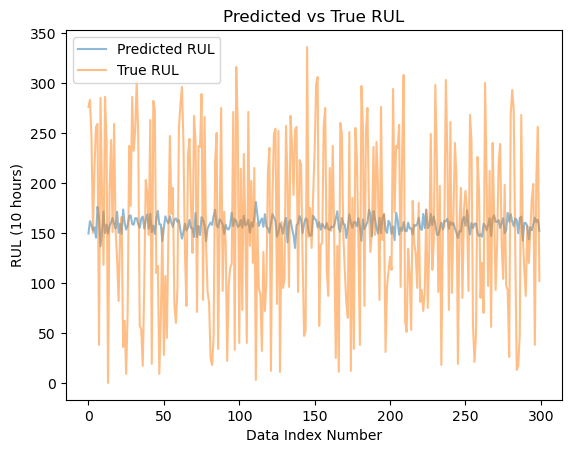

In [56]:
plot_regression(trainloader, rul_est)

In [57]:
rul_est.eval()
objective = nn.MSELoss()

mses = []
for X, y in testloader:
    X = X.to(torch.float32).to(device)
    y = y.to(torch.float32).to(device).squeeze()

    z = enc(X)
    yhat = rul_est(z).squeeze()
    
    loss = objective(yhat, y)
    
    mses.append(loss.item())
    
print(f"Test RMSE: {np.sqrt(np.mean(losses))}")

Test RMSE: 90.21238237699002
